In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_DSprites(nn.Module):
    def __init__(self):
        super(CNN_DSprites, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, kernel_size= 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
class DSprDS(Dataset):
    def __init__(self, split='train', seed=42):
        super().__init__()
        np.random.seed(seed)
        self.root_path = "/".join(os.getcwd().split("/")[:-2]) + "/dataset/dsprites/source/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

        self.img_data = np.load(self.root_path, allow_pickle=True, encoding='bytes')['imgs']
        np.random.shuffle(self.img_data)

        self.ori_len = self.img_data.shape[0]
        
        self.ratio_mapping = {
            "train" : (0, int(self.ori_len*0.95)),
            "valid" : (int(self.ori_len*0.95), int(self.ori_len*0.975)),
            "test" : (int(self.ori_len*0.975), int(self.ori_len))
        }
        
        self.split = split
        self.ratio = self.ratio_mapping[split]
        self.data = self.img_data[self.ratio[0]:self.ratio[1]]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = self.data[idx]

        torch_img = torch.from_numpy(img).unsqueeze(0)

        return torch_img.float()

In [4]:
trainset = DSprDS(split='train')
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=24)
validset = DSprDS(split='valid')
valid_dl = DataLoader(validset, batch_size=256, shuffle=False, num_workers=24)
testset = DSprDS(split='test')
test_dl = DataLoader(testset, batch_size=256, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

700416 18432 18432
2736 72 72


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_DSprites().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.71it/s]


Epoch: 0 - TrainRecLoss: 36.394987372627035 - ValidRecLoss: 24.68319257100423
Epoch: 0 - TrainDivLoss: 13.93492088889518 - ValidDivLoss: 13.30641864405738


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.49it/s]


Epoch: 1 - TrainRecLoss: 23.58278351499323 - ValidRecLoss: 21.606801377402412
Epoch: 1 - TrainDivLoss: 13.34737248483457 - ValidDivLoss: 13.642708354526096


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 40.18it/s]


Epoch: 2 - TrainRecLoss: 20.060785736954003 - ValidRecLoss: 17.968367682562935
Epoch: 2 - TrainDivLoss: 13.971636977809215 - ValidDivLoss: 14.516925348175896


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.42it/s]


Epoch: 3 - TrainRecLoss: 17.264925253670118 - ValidRecLoss: 17.15680061446296
Epoch: 3 - TrainDivLoss: 14.507956609042765 - ValidDivLoss: 14.521237519052294


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.20it/s]


Epoch: 4 - TrainRecLoss: 15.807688163037886 - ValidRecLoss: 14.901888900332981
Epoch: 4 - TrainDivLoss: 14.769678266773447 - ValidDivLoss: 14.885727577739292


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.36it/s]


Epoch: 5 - TrainRecLoss: 14.804519904287238 - ValidRecLoss: 13.965353462431166
Epoch: 5 - TrainDivLoss: 14.934403677084292 - ValidDivLoss: 15.080015142758688


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.28it/s]


Epoch: 6 - TrainRecLoss: 14.027242981550986 - ValidRecLoss: 13.66341103447808
Epoch: 6 - TrainDivLoss: 15.045904395873087 - ValidDivLoss: 15.110436161359152


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.05it/s]


Epoch: 7 - TrainRecLoss: 13.302915547326295 - ValidRecLoss: 12.991543531417847
Epoch: 7 - TrainDivLoss: 15.191120806144692 - ValidDivLoss: 15.057163000106812


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.49it/s]


Epoch: 8 - TrainRecLoss: 12.595115659181138 - ValidRecLoss: 12.009164306852552
Epoch: 8 - TrainDivLoss: 15.349671246015538 - ValidDivLoss: 15.432886825667488


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 40.62it/s]


Epoch: 9 - TrainRecLoss: 12.048032701712602 - ValidRecLoss: 11.977851059701708
Epoch: 9 - TrainDivLoss: 15.463885123618166 - ValidDivLoss: 15.311045752631294


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.86it/s]


Epoch: 10 - TrainRecLoss: 11.56246408523872 - ValidRecLoss: 10.900498125288221
Epoch: 10 - TrainDivLoss: 15.580112213628334 - ValidDivLoss: 15.820159845881992


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.58it/s]


Epoch: 11 - TrainRecLoss: 11.18948890765508 - ValidRecLoss: 10.84445113605923
Epoch: 11 - TrainDivLoss: 15.64228446023506 - ValidDivLoss: 15.672569539811876


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.20it/s]


Epoch: 12 - TrainRecLoss: 10.878540191734047 - ValidRecLoss: 10.783925612767538
Epoch: 12 - TrainDivLoss: 15.701778757293322 - ValidDivLoss: 15.560989605055916


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.09it/s]


Epoch: 13 - TrainRecLoss: 10.621070686836688 - ValidRecLoss: 10.522949324713814
Epoch: 13 - TrainDivLoss: 15.747592058795238 - ValidDivLoss: 15.579919815063477


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.73it/s]


Epoch: 14 - TrainRecLoss: 10.409045463417009 - ValidRecLoss: 9.790604591369629
Epoch: 14 - TrainDivLoss: 15.783130924604093 - ValidDivLoss: 15.906045344140795


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.96it/s]


Epoch: 15 - TrainRecLoss: 10.193029383469744 - ValidRecLoss: 10.01401150226593
Epoch: 15 - TrainDivLoss: 15.823292463146455 - ValidDivLoss: 15.703831010394627


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.19it/s]


Epoch: 16 - TrainRecLoss: 10.010221305646395 - ValidRecLoss: 9.968098746405708
Epoch: 16 - TrainDivLoss: 15.849497331164734 - ValidDivLoss: 16.030800580978394


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.16it/s]


Epoch: 17 - TrainRecLoss: 9.856251241868002 - ValidRecLoss: 9.346330417527092
Epoch: 17 - TrainDivLoss: 15.872102091884056 - ValidDivLoss: 15.938504351509941


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.55it/s]


Epoch: 18 - TrainRecLoss: 9.713018705970363 - ValidRecLoss: 9.869755387306213
Epoch: 18 - TrainDivLoss: 15.890493681904866 - ValidDivLoss: 15.811660766601562


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.74it/s]


Epoch: 19 - TrainRecLoss: 9.560252250983702 - ValidRecLoss: 9.566061284806993
Epoch: 19 - TrainDivLoss: 15.928490969172696 - ValidDivLoss: 16.065133505397373


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.29it/s]


Epoch: 20 - TrainRecLoss: 9.437701461259385 - ValidRecLoss: 8.94859634505378
Epoch: 20 - TrainDivLoss: 15.941998460836578 - ValidDivLoss: 15.960001111030579


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.03it/s]


Epoch: 21 - TrainRecLoss: 9.304693015695316 - ValidRecLoss: 9.223428434795803
Epoch: 21 - TrainDivLoss: 15.954742323585421 - ValidDivLoss: 15.7844979763031


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.02it/s]


Epoch: 22 - TrainRecLoss: 9.21562508498019 - ValidRecLoss: 9.077176253000895
Epoch: 22 - TrainDivLoss: 15.96778136456919 - ValidDivLoss: 15.977986057599386


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.92it/s]


Epoch: 23 - TrainRecLoss: 9.10077121627261 - ValidRecLoss: 8.871103339725071
Epoch: 23 - TrainDivLoss: 15.988456133164858 - ValidDivLoss: 15.985368013381958


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.60it/s]


Epoch: 24 - TrainRecLoss: 8.994147843784756 - ValidRecLoss: 8.565509478251139
Epoch: 24 - TrainDivLoss: 15.999263421833863 - ValidDivLoss: 16.09445556004842


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.62it/s]


Epoch: 25 - TrainRecLoss: 8.906740506490072 - ValidRecLoss: 8.774637553426954
Epoch: 25 - TrainDivLoss: 16.023532695937575 - ValidDivLoss: 16.048241549068027


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.74it/s]


Epoch: 26 - TrainRecLoss: 8.815699460213644 - ValidRecLoss: 8.35796974102656
Epoch: 26 - TrainDivLoss: 16.035920553388653 - ValidDivLoss: 16.201039102342392


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.03it/s]


Epoch: 27 - TrainRecLoss: 8.745373375583114 - ValidRecLoss: 8.71338669459025
Epoch: 27 - TrainDivLoss: 16.042747010961612 - ValidDivLoss: 16.007660004827713


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.34it/s]


Epoch: 28 - TrainRecLoss: 8.657061249714845 - ValidRecLoss: 8.325733992788527
Epoch: 28 - TrainDivLoss: 16.051022145831794 - ValidDivLoss: 16.039747145440842


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.33it/s]


Epoch: 29 - TrainRecLoss: 8.55903403225698 - ValidRecLoss: 8.570180694262186
Epoch: 29 - TrainDivLoss: 16.073434307212718 - ValidDivLoss: 16.063098496860928


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.11it/s]


Epoch: 30 - TrainRecLoss: 8.488323444337176 - ValidRecLoss: 8.593023949199253
Epoch: 30 - TrainDivLoss: 16.073712358000684 - ValidDivLoss: 15.882678906122843


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.94it/s]


Epoch: 31 - TrainRecLoss: 8.429673696644823 - ValidRecLoss: 8.242064429654015
Epoch: 31 - TrainDivLoss: 16.078861477430802 - ValidDivLoss: 16.094181272718643


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.98it/s]


Epoch: 32 - TrainRecLoss: 8.372423899801154 - ValidRecLoss: 8.054097374280294
Epoch: 32 - TrainDivLoss: 16.09409343952324 - ValidDivLoss: 16.18038664923774


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.26it/s]


Epoch: 33 - TrainRecLoss: 8.300380389069954 - ValidRecLoss: 8.1487754450904
Epoch: 33 - TrainDivLoss: 16.09060989520703 - ValidDivLoss: 16.115535842047798


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.64it/s]


Epoch: 34 - TrainRecLoss: 8.224483562143226 - ValidRecLoss: 8.076250659094917
Epoch: 34 - TrainDivLoss: 16.108193834971267 - ValidDivLoss: 16.096867667304146


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.48it/s]


Epoch: 35 - TrainRecLoss: 8.172055261351211 - ValidRecLoss: 7.9098619023958845
Epoch: 35 - TrainDivLoss: 16.112168500297948 - ValidDivLoss: 16.118379765086704


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.95it/s]


Epoch: 36 - TrainRecLoss: 8.124060747741956 - ValidRecLoss: 8.024555053975847
Epoch: 36 - TrainDivLoss: 16.112169422949965 - ValidDivLoss: 15.957392891248068


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.61it/s]


Epoch: 37 - TrainRecLoss: 8.04323428172117 - ValidRecLoss: 7.9101242952876625
Epoch: 37 - TrainDivLoss: 16.128529014991738 - ValidDivLoss: 16.095726291338604


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.30it/s]


Epoch: 38 - TrainRecLoss: 7.990286629973796 - ValidRecLoss: 7.647117727332645
Epoch: 38 - TrainDivLoss: 16.1311381110671 - ValidDivLoss: 16.206863019201492


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.80it/s]


Epoch: 39 - TrainRecLoss: 7.921823669943893 - ValidRecLoss: 7.747788409392039
Epoch: 39 - TrainDivLoss: 16.14092348228421 - ValidDivLoss: 16.218799577818977


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.23it/s]


Epoch: 40 - TrainRecLoss: 7.883704147666519 - ValidRecLoss: 7.765099333392249
Epoch: 40 - TrainDivLoss: 16.136681637220214 - ValidDivLoss: 16.22973855336507


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.22it/s]


Epoch: 41 - TrainRecLoss: 7.822563171909566 - ValidRecLoss: 7.65183734231525
Epoch: 41 - TrainDivLoss: 16.14553037163807 - ValidDivLoss: 16.193899035453796


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.15it/s]


Epoch: 42 - TrainRecLoss: 7.763230528747826 - ValidRecLoss: 7.747806012630463
Epoch: 42 - TrainDivLoss: 16.158397773901623 - ValidDivLoss: 16.12865658601125


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.45it/s]


Epoch: 43 - TrainRecLoss: 7.714714395372491 - ValidRecLoss: 7.6433627737893
Epoch: 43 - TrainDivLoss: 16.15613447295295 - ValidDivLoss: 16.21163747045729


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.36it/s]


Epoch: 44 - TrainRecLoss: 7.675446035220609 - ValidRecLoss: 7.522242897086674
Epoch: 44 - TrainDivLoss: 16.17368568697868 - ValidDivLoss: 16.1071275472641


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.23it/s]


Epoch: 45 - TrainRecLoss: 7.601659215333169 - ValidRecLoss: 7.687077389823066
Epoch: 45 - TrainDivLoss: 16.169860046509413 - ValidDivLoss: 16.216834942499798


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.47it/s]


Epoch: 46 - TrainRecLoss: 7.558985656465006 - ValidRecLoss: 7.352862099806468
Epoch: 46 - TrainDivLoss: 16.185367856806483 - ValidDivLoss: 16.231054226557415


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.47it/s]


Epoch: 47 - TrainRecLoss: 7.5196304577484465 - ValidRecLoss: 7.293573982185787
Epoch: 47 - TrainDivLoss: 16.191087098498095 - ValidDivLoss: 16.215910222795273


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.51it/s]


Epoch: 48 - TrainRecLoss: 7.473998453707723 - ValidRecLoss: 7.45094946357939
Epoch: 48 - TrainDivLoss: 16.19215530087376 - ValidDivLoss: 16.118790162934197


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.35it/s]


Epoch: 49 - TrainRecLoss: 7.41854475116172 - ValidRecLoss: 7.371765249305302
Epoch: 49 - TrainDivLoss: 16.198123593776547 - ValidDivLoss: 16.170090874036152


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.10it/s]


Epoch: 50 - TrainRecLoss: 7.377848991350821 - ValidRecLoss: 7.207560479640961
Epoch: 50 - TrainDivLoss: 16.197059073294813 - ValidDivLoss: 16.190537121560837


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.97it/s]


Epoch: 51 - TrainRecLoss: 7.339579977835828 - ValidRecLoss: 7.244937651687199
Epoch: 51 - TrainDivLoss: 16.206928062160113 - ValidDivLoss: 16.240826182895237


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.61it/s]


Epoch: 52 - TrainRecLoss: 7.292483466933345 - ValidRecLoss: 7.227574441168043
Epoch: 52 - TrainDivLoss: 16.207125793075004 - ValidDivLoss: 16.136434541808235


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 37.87it/s]


Epoch: 53 - TrainRecLoss: 7.252444601372669 - ValidRecLoss: 6.918579671117994
Epoch: 53 - TrainDivLoss: 16.218654843798856 - ValidDivLoss: 16.37298795912001


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.58it/s]


Epoch: 54 - TrainRecLoss: 7.2100788562269935 - ValidRecLoss: 7.152864489290449
Epoch: 54 - TrainDivLoss: 16.225296255789306 - ValidDivLoss: 16.169235070546467


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.55it/s]


Epoch: 55 - TrainRecLoss: 7.159756444351018 - ValidRecLoss: 7.079252964920467
Epoch: 55 - TrainDivLoss: 16.231942471007855 - ValidDivLoss: 16.26667597558763


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.23it/s]


Epoch: 56 - TrainRecLoss: 7.111064194238674 - ValidRecLoss: 7.051304817199707
Epoch: 56 - TrainDivLoss: 16.236383713128273 - ValidDivLoss: 16.16628446843889


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.36it/s]


Epoch: 57 - TrainRecLoss: 7.078711655404833 - ValidRecLoss: 6.9700836009449425
Epoch: 57 - TrainDivLoss: 16.24081852212984 - ValidDivLoss: 16.2143325275845


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.49it/s]


Epoch: 58 - TrainRecLoss: 7.037242875810255 - ValidRecLoss: 6.978496538268195
Epoch: 58 - TrainDivLoss: 16.245130265316767 - ValidDivLoss: 16.21841691599952


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.16it/s]


Epoch: 59 - TrainRecLoss: 7.002413883195286 - ValidRecLoss: 6.989242606692844
Epoch: 59 - TrainDivLoss: 16.247186828775014 - ValidDivLoss: 16.312127325269913


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.73it/s]


Epoch: 60 - TrainRecLoss: 6.9686375631574995 - ValidRecLoss: 6.89513846900728
Epoch: 60 - TrainDivLoss: 16.25025453553562 - ValidDivLoss: 16.219200081295437


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.91it/s]


Epoch: 61 - TrainRecLoss: 6.92440004638064 - ValidRecLoss: 7.0938035580847
Epoch: 61 - TrainDivLoss: 16.257335097469085 - ValidDivLoss: 16.188302013609146


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 44.53it/s]


Epoch: 62 - TrainRecLoss: 6.889402892331631 - ValidRecLoss: 6.823063453038533
Epoch: 62 - TrainDivLoss: 16.262131330562614 - ValidDivLoss: 16.253140608469646


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.77it/s]


Epoch: 63 - TrainRecLoss: 6.855445963074589 - ValidRecLoss: 6.792152477635278
Epoch: 63 - TrainDivLoss: 16.26811521025429 - ValidDivLoss: 16.254322449366253


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.64it/s]


Epoch: 64 - TrainRecLoss: 6.8218937612067885 - ValidRecLoss: 6.682689176665412
Epoch: 64 - TrainDivLoss: 16.27061001494614 - ValidDivLoss: 16.242466025882297


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 37.78it/s]


Epoch: 65 - TrainRecLoss: 6.790069342182393 - ValidRecLoss: 6.731597211625841
Epoch: 65 - TrainDivLoss: 16.265695625927016 - ValidDivLoss: 16.256121502982246


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.44it/s]


Epoch: 66 - TrainRecLoss: 6.7571245043249855 - ValidRecLoss: 6.747725347677867
Epoch: 66 - TrainDivLoss: 16.27589274010463 - ValidDivLoss: 16.227938254674275


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.85it/s]


Epoch: 67 - TrainRecLoss: 6.719043233938384 - ValidRecLoss: 6.692664384841919
Epoch: 67 - TrainDivLoss: 16.28355376553117 - ValidDivLoss: 16.28664819399516


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.25it/s]


Epoch: 68 - TrainRecLoss: 6.696554478671816 - ValidRecLoss: 6.695237113369836
Epoch: 68 - TrainDivLoss: 16.280443842648065 - ValidDivLoss: 16.258764849768745


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.81it/s]


Epoch: 69 - TrainRecLoss: 6.651399265430127 - ValidRecLoss: 6.607518944475386
Epoch: 69 - TrainDivLoss: 16.30178237449356 - ValidDivLoss: 16.33527734544542


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.10it/s]


Epoch: 70 - TrainRecLoss: 6.630248160912976 - ValidRecLoss: 6.572660777303907
Epoch: 70 - TrainDivLoss: 16.29392879329927 - ValidDivLoss: 16.243214554256863


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.78it/s]


Epoch: 71 - TrainRecLoss: 6.595956018270805 - ValidRecLoss: 6.616442230012682
Epoch: 71 - TrainDivLoss: 16.30476824721398 - ValidDivLoss: 16.2786410384708


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.65it/s]


Epoch: 72 - TrainRecLoss: 6.570897272107197 - ValidRecLoss: 6.503716270128886
Epoch: 72 - TrainDivLoss: 16.311685812403585 - ValidDivLoss: 16.359820153978134


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 41.56it/s]


Epoch: 73 - TrainRecLoss: 6.541357144451978 - ValidRecLoss: 6.430537581443787
Epoch: 73 - TrainDivLoss: 16.31225445465735 - ValidDivLoss: 16.391156037648518


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.17it/s]


Epoch: 74 - TrainRecLoss: 6.515581822360468 - ValidRecLoss: 6.447129395272997
Epoch: 74 - TrainDivLoss: 16.317445767553227 - ValidDivLoss: 16.313251680798


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.71it/s]


Epoch: 75 - TrainRecLoss: 6.486247039329239 - ValidRecLoss: 6.536054604583317
Epoch: 75 - TrainDivLoss: 16.318096008914257 - ValidDivLoss: 16.28620245721605


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.75it/s]


Epoch: 76 - TrainRecLoss: 6.461878493341089 - ValidRecLoss: 6.4248605370521545
Epoch: 76 - TrainDivLoss: 16.323017033917164 - ValidDivLoss: 16.296130895614624


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.62it/s]


Epoch: 77 - TrainRecLoss: 6.442200080518834 - ValidRecLoss: 6.4721653660138445
Epoch: 77 - TrainDivLoss: 16.324820466906008 - ValidDivLoss: 16.30329868528578


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.44it/s]


Epoch: 78 - TrainRecLoss: 6.414632181675113 - ValidRecLoss: 6.384533617231581
Epoch: 78 - TrainDivLoss: 16.32860303482814 - ValidDivLoss: 16.34844160079956


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.71it/s]


Epoch: 79 - TrainRecLoss: 6.397141218185425 - ValidRecLoss: 6.299052410655552
Epoch: 79 - TrainDivLoss: 16.32339880689543 - ValidDivLoss: 16.36220047208998


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.84it/s]


Epoch: 80 - TrainRecLoss: 6.378076915503942 - ValidRecLoss: 6.401772220929463
Epoch: 80 - TrainDivLoss: 16.338266733097054 - ValidDivLoss: 16.2945450146993


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.00it/s]


Epoch: 81 - TrainRecLoss: 6.356573087778705 - ValidRecLoss: 6.350722478495704
Epoch: 81 - TrainDivLoss: 16.341117596068578 - ValidDivLoss: 16.303420543670654


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 37.58it/s]


Epoch: 82 - TrainRecLoss: 6.33549092561878 - ValidRecLoss: 6.242633746729957
Epoch: 82 - TrainDivLoss: 16.338521128509477 - ValidDivLoss: 16.392549170388115


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.05it/s]


Epoch: 83 - TrainRecLoss: 6.317103025683186 - ValidRecLoss: 6.273683607578278
Epoch: 83 - TrainDivLoss: 16.343657894441257 - ValidDivLoss: 16.341150124867756


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.14it/s]


Epoch: 84 - TrainRecLoss: 6.29889387990299 - ValidRecLoss: 6.295040229956309
Epoch: 84 - TrainDivLoss: 16.342388312021892 - ValidDivLoss: 16.324739985995823


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.50it/s]


Epoch: 85 - TrainRecLoss: 6.282066001355299 - ValidRecLoss: 6.167190227243635
Epoch: 85 - TrainDivLoss: 16.347036998174342 - ValidDivLoss: 16.37053524123298


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.30it/s]


Epoch: 86 - TrainRecLoss: 6.267970721798333 - ValidRecLoss: 6.2711803913116455
Epoch: 86 - TrainDivLoss: 16.355172233971935 - ValidDivLoss: 16.319940169652302


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.30it/s]


Epoch: 87 - TrainRecLoss: 6.249981502517622 - ValidRecLoss: 6.256733106242286
Epoch: 87 - TrainDivLoss: 16.363678941252637 - ValidDivLoss: 16.340329991446602


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.42it/s]


Epoch: 88 - TrainRecLoss: 6.237188854587008 - ValidRecLoss: 6.221223917272356
Epoch: 88 - TrainDivLoss: 16.36370269108934 - ValidDivLoss: 16.348536756303574


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.15it/s]


Epoch: 89 - TrainRecLoss: 6.228697553189875 - ValidRecLoss: 6.203929583231608
Epoch: 89 - TrainDivLoss: 16.364137433425725 - ValidDivLoss: 16.34389548831516


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.10it/s]


Epoch: 90 - TrainRecLoss: 6.22059593336624 - ValidRecLoss: 6.17213096221288
Epoch: 90 - TrainDivLoss: 16.363460837051882 - ValidDivLoss: 16.373584429423016


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.10it/s]


Epoch: 91 - TrainRecLoss: 6.210554677491997 - ValidRecLoss: 6.134966962867313
Epoch: 91 - TrainDivLoss: 16.36757210541887 - ValidDivLoss: 16.388099749883015


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.29it/s]


Epoch: 92 - TrainRecLoss: 6.20479264593961 - ValidRecLoss: 6.141433742311266
Epoch: 92 - TrainDivLoss: 16.36315756234509 - ValidDivLoss: 16.368535068300034


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.41it/s]


Epoch: 93 - TrainRecLoss: 6.198818180470439 - ValidRecLoss: 6.2169765962494745
Epoch: 93 - TrainDivLoss: 16.36263066077093 - ValidDivLoss: 16.332391606436836


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.63it/s]


Epoch: 94 - TrainRecLoss: 6.189054109025419 - ValidRecLoss: 6.166131787829929
Epoch: 94 - TrainDivLoss: 16.364952106224862 - ValidDivLoss: 16.370440748002792


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.63it/s]


Epoch: 95 - TrainRecLoss: 6.189245699441921 - ValidRecLoss: 6.16774101389779
Epoch: 95 - TrainDivLoss: 16.36111977713847 - ValidDivLoss: 16.36319086286757


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.25it/s]


Epoch: 96 - TrainRecLoss: 6.176619428640221 - ValidRecLoss: 6.172303133540684
Epoch: 96 - TrainDivLoss: 16.369522593871892 - ValidDivLoss: 16.352703465355766


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 39.19it/s]


Epoch: 97 - TrainRecLoss: 6.177939823147846 - ValidRecLoss: 6.1533391740587025
Epoch: 97 - TrainDivLoss: 16.363392404645506 - ValidDivLoss: 16.353156116273666


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.52it/s]


Epoch: 98 - TrainRecLoss: 6.181691420008565 - ValidRecLoss: 6.189012878470951
Epoch: 98 - TrainDivLoss: 16.36362788063741 - ValidDivLoss: 16.354954957962036


100%|████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 38.28it/s]

Epoch: 99 - TrainRecLoss: 6.175272266767179 - ValidRecLoss: 6.137138929631975
Epoch: 99 - TrainDivLoss: 16.367041336165535 - ValidDivLoss: 16.36558156543308


In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

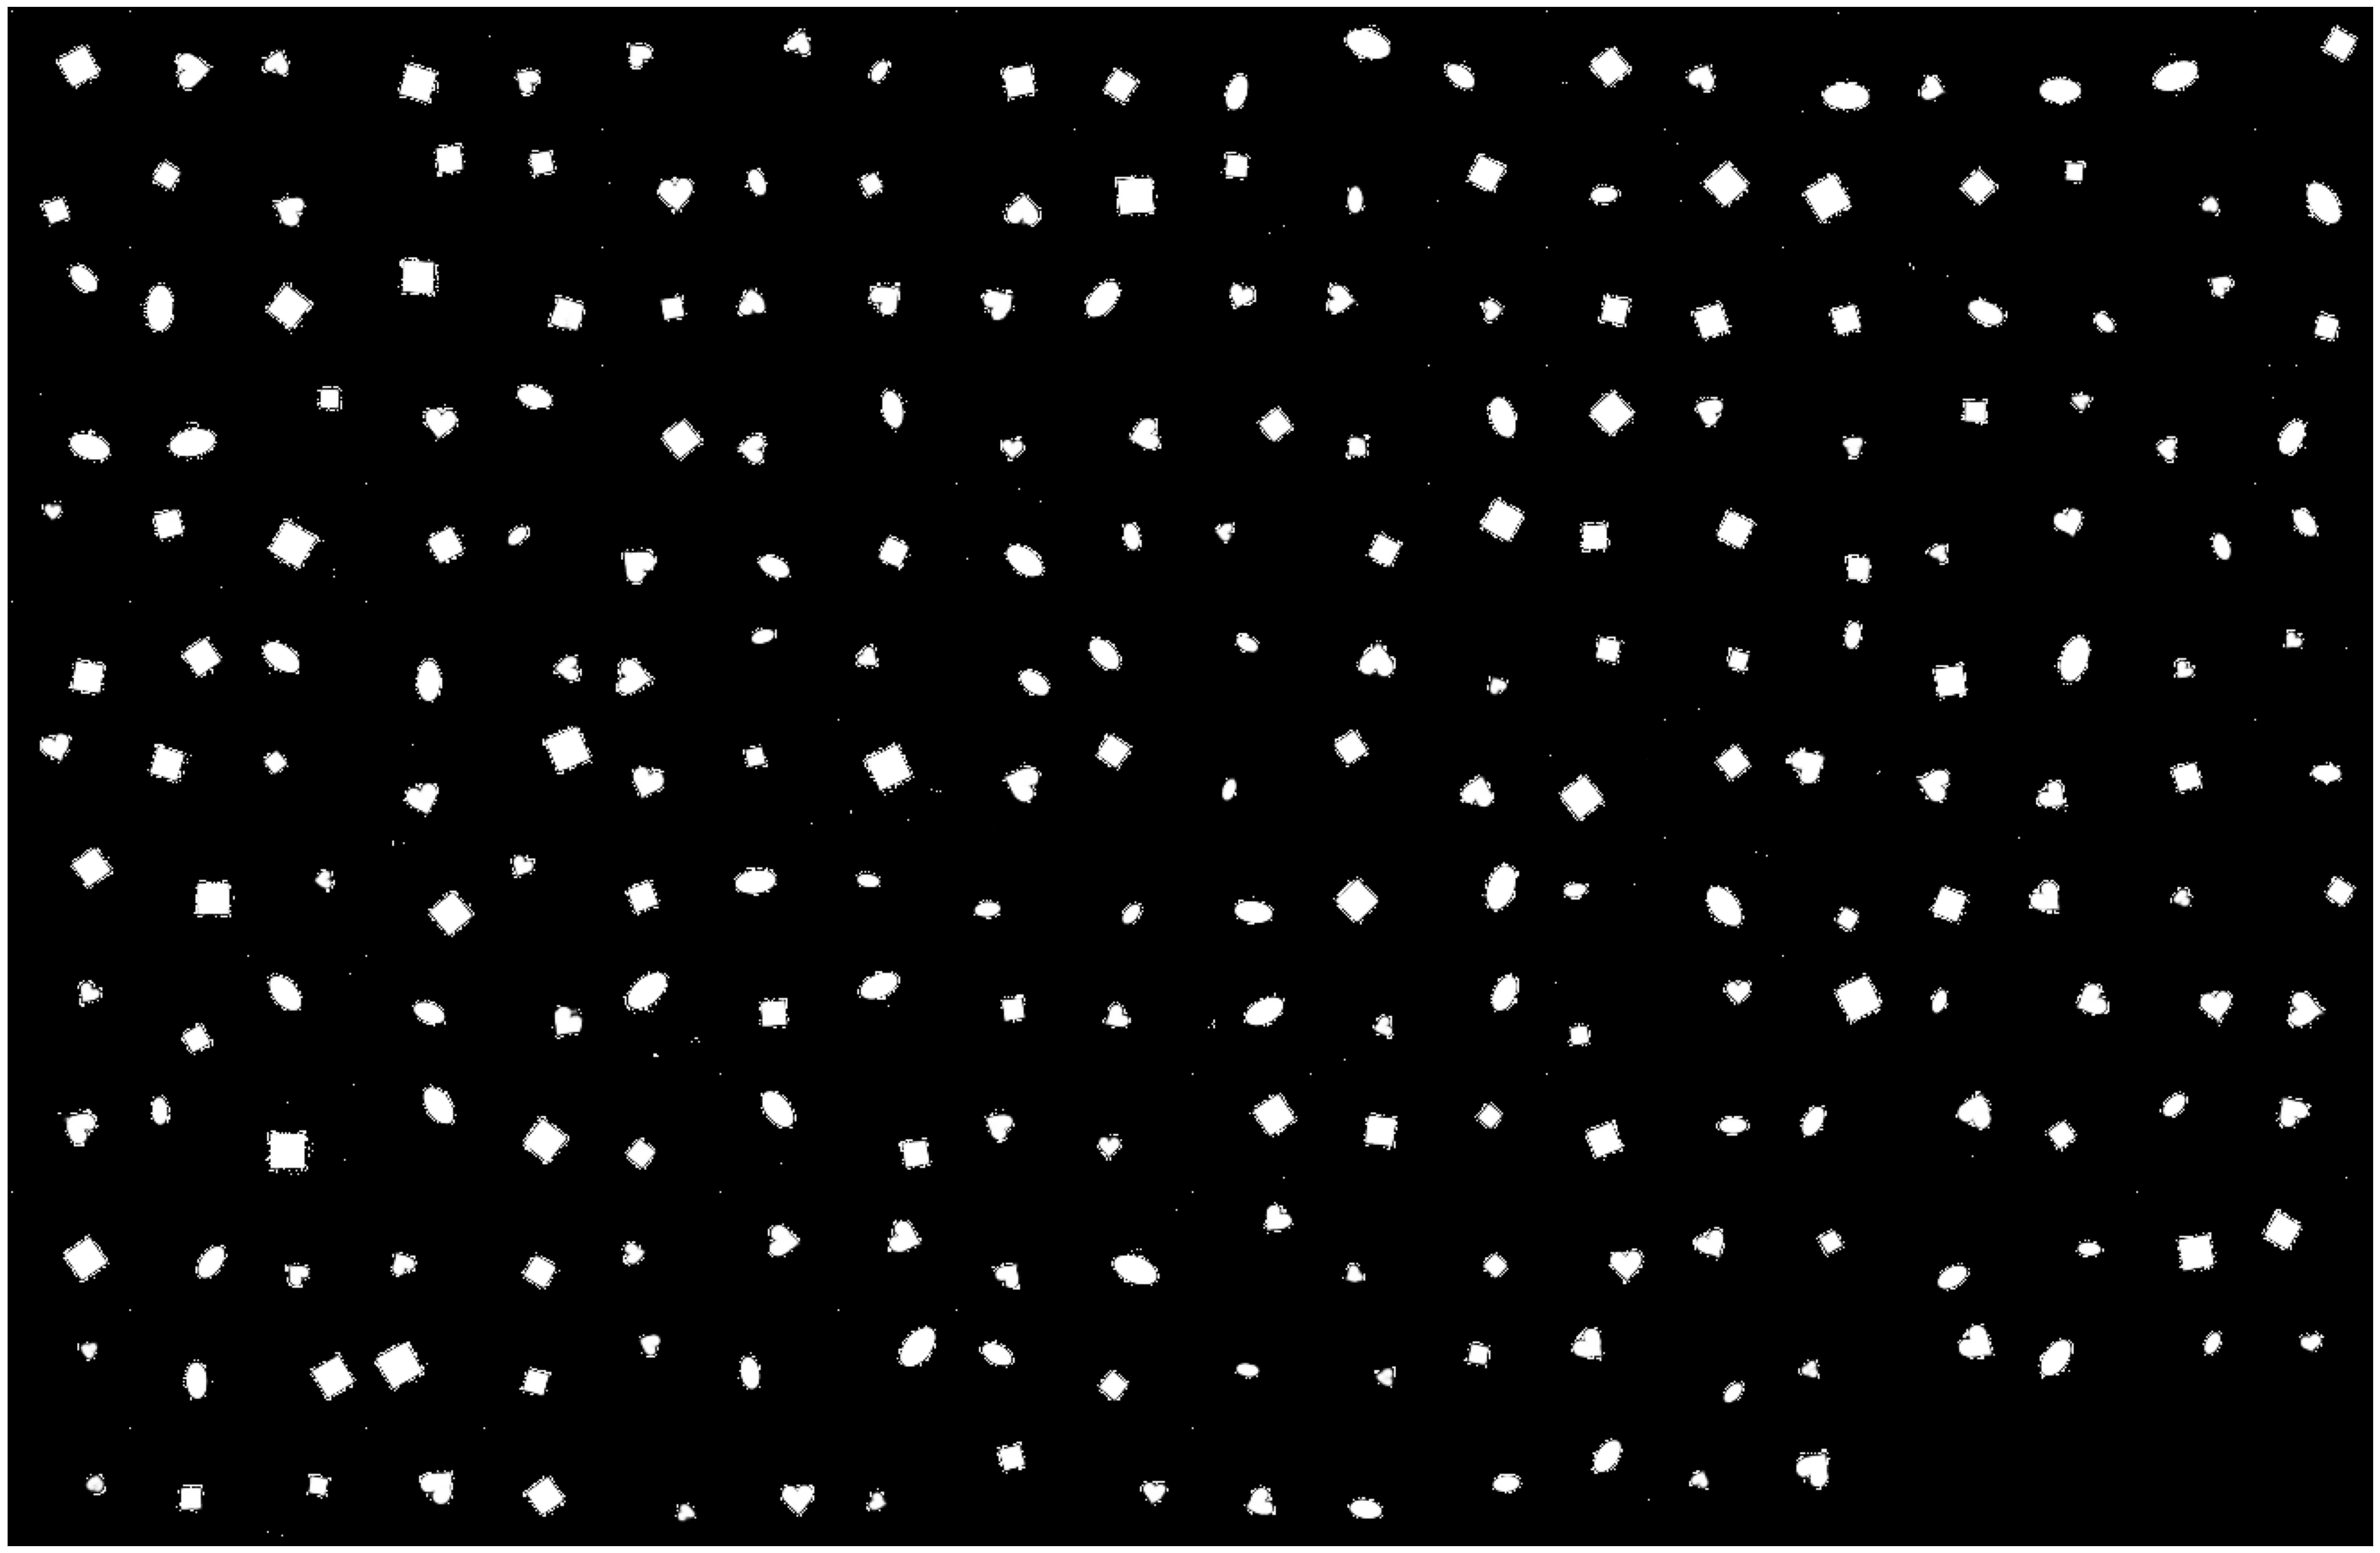

In [10]:
test_input = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons, nrow = 20)
show(grid)


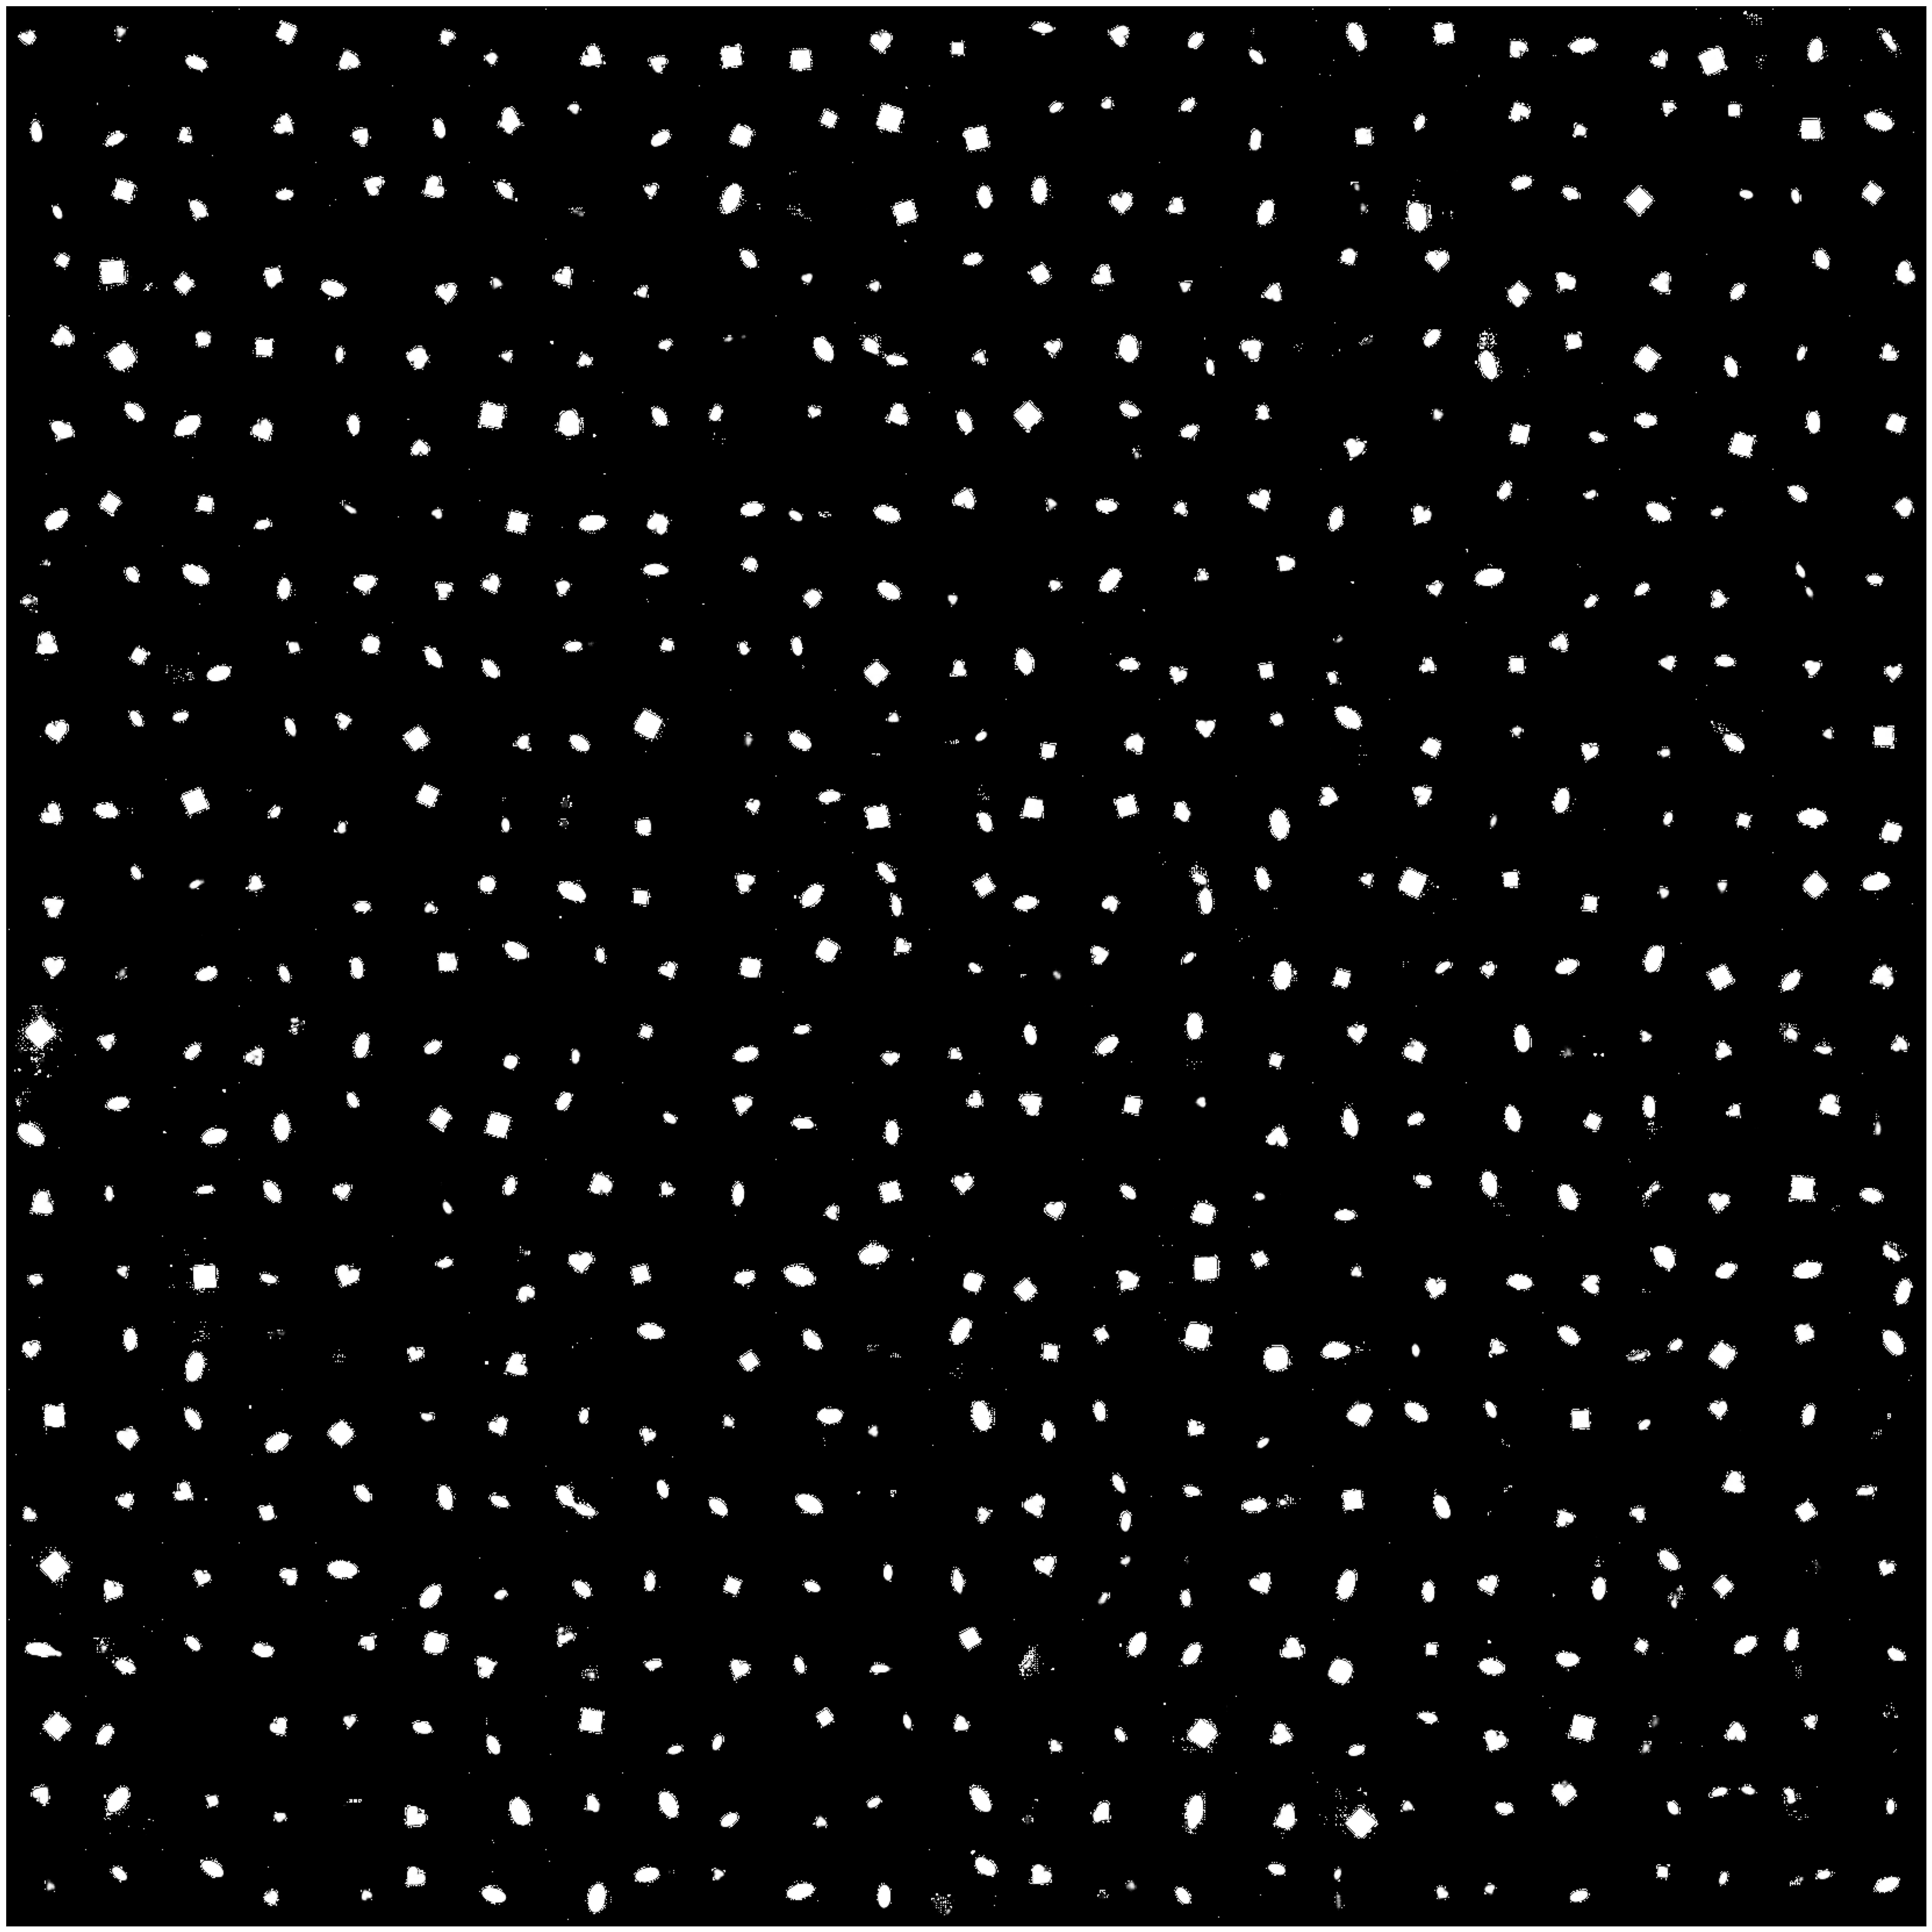

In [11]:
z = torch.randn(625, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=25)
show(grid)